# Imports

In [1]:
import os
import sys
import glob
import json
import nltk, re, string, collections
from nltk.util import ngrams
from collections import Counter
import pandas as pd
from nltk.tokenize import word_tokenize 

import grpc

import zemberek_grpc.language_id_pb2 as z_langid
import zemberek_grpc.language_id_pb2_grpc as z_langid_g
import zemberek_grpc.normalization_pb2 as z_normalization
import zemberek_grpc.normalization_pb2_grpc as z_normalization_g
import zemberek_grpc.preprocess_pb2 as z_preprocess
import zemberek_grpc.preprocess_pb2_grpc as z_preprocess_g
import zemberek_grpc.morphology_pb2 as z_morphology
import zemberek_grpc.morphology_pb2_grpc as z_morphology_g

# readJson function

In [2]:
def readJson(fileName):
    f = open(file, "r", encoding='utf-8')
    jsonData = json.load(f)
    words = ""
    for _, value in jsonData.items():
        if(len(value) > len(words)):
            words = value
    return words

# Find ngrams with stopwords

In [3]:
path = "testDatasets/*.json"
files = glob.glob(path)

words = ""

for file in files:
    jsonWords = readJson(file)
    words = words + jsonWords
    
tokenized_words = [word.lower() for word in words.split() if len(word) > 1 and re.match("^[A-Z0-9a-zğüşöçİĞÜŞÖÇ]*$", word)]

ngram_list = [
    {"n": 1, "prefix": "unigram"},
    {"n": 2, "prefix": "bigram"},
    {"n": 3, "prefix": "trigram"}
]

if not os.path.exists("outputs"):
    os.mkdir("outputs")

for ngram in ngram_list:
    n = ngrams(tokenized_words, ngram['n'])
    nFreq = collections.Counter(n)
    df = pd.DataFrame(nFreq.most_common(None), columns = ['Words', 'Frequency'])
    df = df.sort_values(by='Frequency', ascending=False)
    p = './outputs/' + ngram['prefix'] + '-with-stopwords.csv'
    df.to_csv(p, index = True, header=True)
    

# Read stopwords file

In [4]:
file = open("stopwords.txt", "r", newline='', encoding='utf-8')
result = file.read()
stopwords = word_tokenize(result)

# Pre Processing

In [5]:
channel = grpc.insecure_channel('localhost:6789')

langid_stub = z_langid_g.LanguageIdServiceStub(channel)
normalization_stub = z_normalization_g.NormalizationServiceStub(channel)
preprocess_stub = z_preprocess_g.PreprocessingServiceStub(channel)
morphology_stub = z_morphology_g.MorphologyServiceStub(channel)

def analyze(i):
    response = morphology_stub.AnalyzeSentence(z_morphology.SentenceAnalysisRequest(input=i))
    return response;
    
def pre_processing(words):
    lemmas_string = ""
    analysis_result = analyze(words)
    for a in analysis_result.results:
        best = a.best
        if(best.lemmas[-1] == "UNK"):
            lemmas_string = lemmas_string + " " + a.token
        else:
            lemmas_string = lemmas_string + " " + best.lemmas[-1]
        
        
    return lemmas_string
    

# Find ngrams without stopwords

In [6]:
path = "testDatasets/*.json"
files = glob.glob(path)

words = ""

for file in files:
    jsonWords = (readJson(file))
    words = words + jsonWords
    
tokenized_words = [word.lower() for word in words.split() if word.lower() not in stopwords and len(word) > 1 and re.match("^[A-Z0-9a-zğüşöçİĞÜŞÖÇ]*$", word)]

ngram_list = [
    {"n": 1, "prefix": "unigram"},
    {"n": 2, "prefix": "bigram"},
    {"n": 3, "prefix": "trigram"}
]

for ngram in ngram_list:
    n = ngrams(tokenized_words, ngram['n'])
    nFreq = collections.Counter(n)
    df = pd.DataFrame(nFreq.most_common(None), columns = ['Words', 'Frequency'])
    df = df.sort_values(by='Frequency', ascending=False)
    p = './outputs/' + ngram['prefix'] + '-without-stopwords.csv'
    df.to_csv(p, index = True, header=True)
    

# Print filtered tokens to file

In [7]:
file = open('./filtered-tokens.txt','w', encoding='utf-8')
for word in tokenized_words:
    file.write(" "+word.lower())

file.close()

# Find collocations

# Methods

In [9]:
if not os.path.exists("methods"):
    os.mkdir("methods")
    os.mkdir("methods/bigram/")
    os.mkdir("methods/trigram/")

## Raw Frequency


--------Bigram with Raw Frequency--------


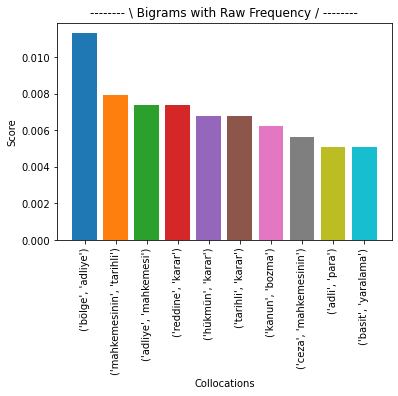

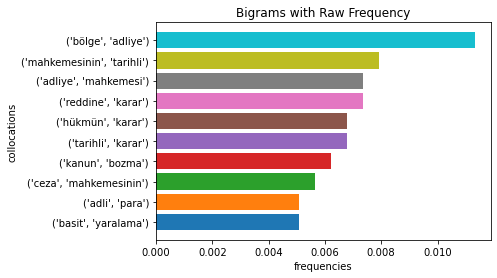

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
bigramRawFreqTable = pd.DataFrame(list(bigram_finder.score_ngrams(bigrams.raw_freq)), columns=['Bigram','raw_freq']).sort_values(by='raw_freq', ascending=False)
bigramRawFreqTable.to_csv('./methods/bigram/bigramRawFreqTable.csv', index = False, header=True)
print("\n--------Bigram with Raw Frequency--------")
data = pd.read_csv("./methods/bigram/bigramRawFreqTable.csv") 
words = []
words = data.head(10)['Bigram']
freqs = data.head(10)['raw_freq']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
reversed_words = words[::-1]
reversed_freqs = freqs[::-1]
plt.bar(words,freqs, color=colors)
plt.title('-------- \ Bigrams with Raw Frequency / --------')
plt.xticks(rotation=90)
plt.xlabel('Collocations')
plt.ylabel('Score')
plt.show() 

plt.barh(reversed_words, reversed_freqs, color=colors)
plt.ylabel("collocations")
plt.xlabel("frequencies")
plt.title("Bigrams with Raw Frequency")
plt.show()

trigramRawFreqTable = pd.DataFrame(list(trigram_finder.score_ngrams(trigrams.raw_freq)), columns=['Trigram','raw_freq']).sort_values(by='raw_freq', ascending=False)
trigramRawFreqTable.to_csv('./methods/trigram/trigramRawFreqTable.csv', index = False, header=True)

## PMI

In [11]:
bigramPMITable = pd.DataFrame(list(bigram_finder.score_ngrams(bigrams.pmi)), columns=['Bigram','PMI']).sort_values(by='PMI', ascending=False)
bigramPMITable.to_csv('./methods/bigram/bigramPMITable.csv', index = False, header=True)

trigramPMITable = pd.DataFrame(list(trigram_finder.score_ngrams(trigrams.pmi)), columns=['Trigram','PMI']).sort_values(by='PMI', ascending=False)
trigramPMITable.to_csv('./methods/trigram/trigramPMITable.csv', index = False, header=True)

## T-test

In [12]:
bigramTtable = pd.DataFrame(list(bigram_finder.score_ngrams(bigrams.student_t)), columns=['Bigram','t']).sort_values(by='t', ascending=False)
bigramTtable.to_csv('./methods/bigram/bigramTtable.csv', index = False, header=True)

trigramTtable = pd.DataFrame(list(trigram_finder.score_ngrams(trigrams.student_t)), columns=['Trigram','t']).sort_values(by='t', ascending=False)
trigramTtable.to_csv('./methods/trigram/trigramTtable.csv', index = False, header=True)

## Chi-Square

In [13]:
bigramChiTable = pd.DataFrame(list(bigram_finder.score_ngrams(bigrams.chi_sq)), columns=['Bigram','chi-sq']).sort_values(by='chi-sq', ascending=False)
bigramChiTable.to_csv('./methods/bigram/bigramChiTable.csv', index = False, header=True)

trigramChiTable = pd.DataFrame(list(trigram_finder.score_ngrams(trigrams.chi_sq)), columns=['Trigram','chi-sq']).sort_values(by='chi-sq', ascending=False)
trigramChiTable.to_csv('./methods/trigram/trigramChiTable.csv', index = False, header=True)

## Poisson Stirling

In [14]:
bigramPoissonTable = pd.DataFrame(list(bigram_finder.score_ngrams(bigrams.poisson_stirling)), columns=['Bigram','poisson_stirling']).sort_values(by='poisson_stirling', ascending=False)
bigramPoissonTable.to_csv('./methods/bigram/bigramPoissonTable.csv', index = False, header=True)

trigramPoissonTable = pd.DataFrame(list(trigram_finder.score_ngrams(trigrams.poisson_stirling)), columns=['Trigram','poisson_stirling']).sort_values(by='poisson_stirling', ascending=False)
trigramPoissonTable.to_csv('./methods/trigram/trigramPoissonTable.csv', index = False, header=True)

## Likelihood Ratio

In [15]:
bigramLikelihoodTable = pd.DataFrame(list(bigram_finder.score_ngrams(bigrams.likelihood_ratio)), columns=['Bigram','likelihood_ratio']).sort_values(by='likelihood_ratio', ascending=False)
bigramLikelihoodTable.to_csv('./methods/bigram/bigramLikelihoodTable.csv', index = False, header=True)

trigramLikelihoodTable = pd.DataFrame(list(trigram_finder.score_ngrams(trigrams.likelihood_ratio)), columns=['Trigram','likelihood_ratio']).sort_values(by='likelihood_ratio', ascending=False)
trigramLikelihoodTable.to_csv('./methods/trigram/trigramLikelihoodTable.csv', index = False, header=True)

## Jaccard

In [16]:
bigramJaccardTable = pd.DataFrame(list(bigram_finder.score_ngrams(bigrams.jaccard)), columns=['Bigram','jaccard']).sort_values(by='jaccard', ascending=False)
bigramJaccardTable.to_csv('./methods/bigram/bigramJaccardTable.csv', index = False, header=True)

trigramJaccardTable = pd.DataFrame(list(trigram_finder.score_ngrams(trigrams.jaccard)), columns=['Trigram','jaccard']).sort_values(by='jaccard', ascending=False)
trigramJaccardTable.to_csv('./methods/trigram/trigramJaccardTable.csv', index = False, header=True)